Training Convolutional Neural Networks

Swapping the MLP for an CNN to classify MNIST images



In [48]:
#%pip install watermark
#%pip install --upgrade pip
#%pip install torch
#%pip install lightning==2.1.1
#%pip install torchvision==0.20.1
#%pip install matplotlib
#%pip install pandas


In [49]:
%load_ext watermark
%watermark -p torch,lightning --conda

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
torch    : 2.5.1
lightning: 2.1.1

conda environment: n/a



In [50]:
import lightning as L
import torch
import torchvision
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from shared_utilities import LightningModel, MnistDataModule, plot_loss_and_acc

In [51]:
L.pytorch.seed_everything(123)

dm = MnistDataModule(batch_size=64)
dm.prepare_data()
dm.setup(False)

Seed set to 123


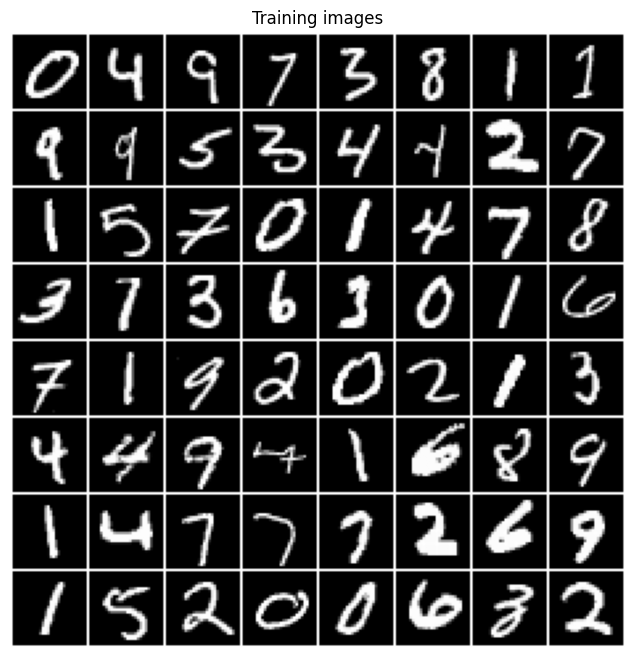

In [52]:
for images, labels in dm.train_dataloader():  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))

plt.show()

In [53]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),
            
            # 2nd hidden layer
            torch.nn.Linear(100, 50),
            torch.nn.BatchNorm1d(50),
            torch.nn.ReLU(),
            
            # output layer
            torch.nn.Linear(50, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [54]:
class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.cnn_layers = torch.nn.Sequential(

            torch.nn.Conv2d(1, 3, kernel_size=5),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            
            torch.nn.Conv2d(3, 16, kernel_size=3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),        
            
            torch.nn.Conv2d(16, 32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), 
        )
        
        self.fc_layers = torch.nn.Sequential(
            # hidden layer
            torch.nn.Linear(32, 20),
            torch.nn.BatchNorm1d(20),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(20, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        # print(x.shape)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc_layers(x)
        return logits

In [55]:
%%capture --no-display

L.seed_everything(123)
dm = MnistDataModule()

pytorch_model = PyTorchCNN(num_classes=10)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
    max_epochs=10,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Seed set to 123
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [56]:
trainer.fit(model=lightning_model, datamodule=dm)


  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchCNN         | 6.2 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 65.33it/s]

C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 859/859 [00:26<00:00, 32.10it/s, v_num=12, val_loss=0.0659, val_acc=0.980, train_acc=0.989]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 859/859 [00:26<00:00, 32.08it/s, v_num=12, val_loss=0.0659, val_acc=0.980, train_acc=0.989]


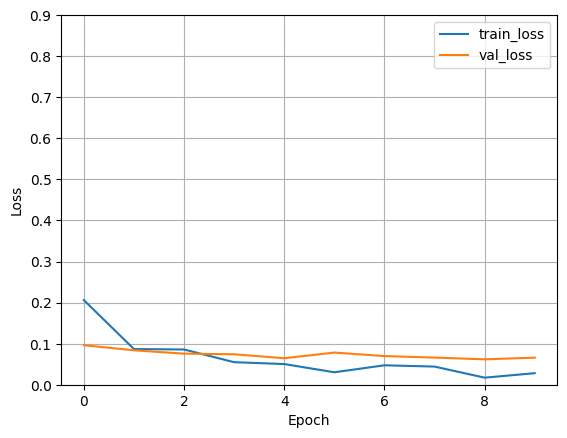

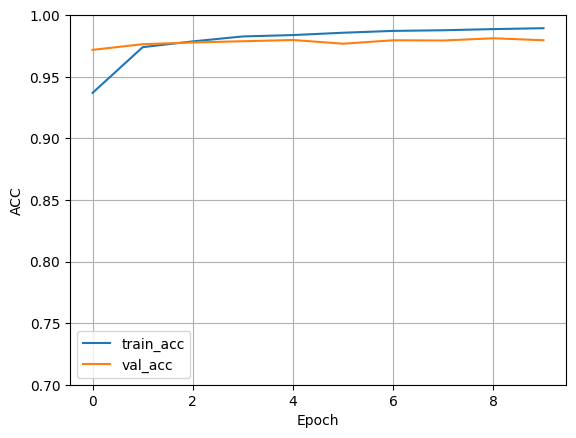

In [57]:
plot_loss_and_acc(trainer.logger.log_dir)

In [58]:
trainer.test(model=lightning_model, datamodule=dm)

C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 60.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9848999977111816
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9848999977111816}]

In [59]:
import torchvision.models as models

resnet_model = models.resnet18(pretrained = True)

# https://discuss.pytorch.org/t/changing-in-features-in-fc-layer-for-resnet18-in-torchvision/21445/2
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, 10)

# https://stackoverflow.com/questions/58364963/how-to-change-the-first-convolution-of-a-pretrained-resnet-in-tensorflow
resnet_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size = 7, stride = (2, 2), padding = (3, 3), bias = False)

lightning_model = LightningModel(model=resnet_model, learning_rate=0.1)

#No data augmentation
dm = MnistDataModule(batch_size=64)
dm.prepare_data()
dm.setup(False)

trainer = L.Trainer(
    max_epochs=5,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="res_net_model_no_alterations"),
    deterministic=True,
)

C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [60]:
trainer.fit(model=lightning_model, datamodule=dm)

Missing logger folder: logs/res_net_model_no_alterations

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.2 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s]

C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:  32%|███▏      | 271/859 [00:53<01:56,  5.03it/s, v_num=0]

C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


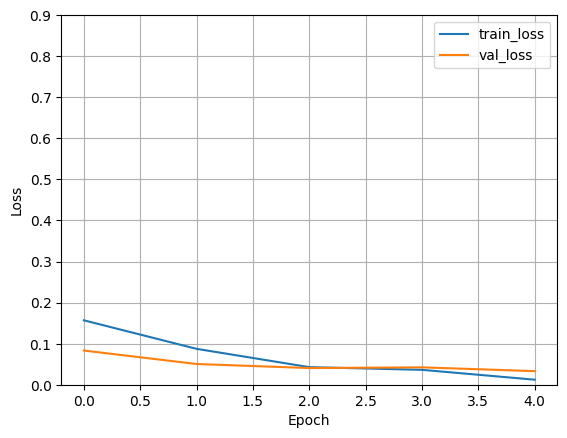

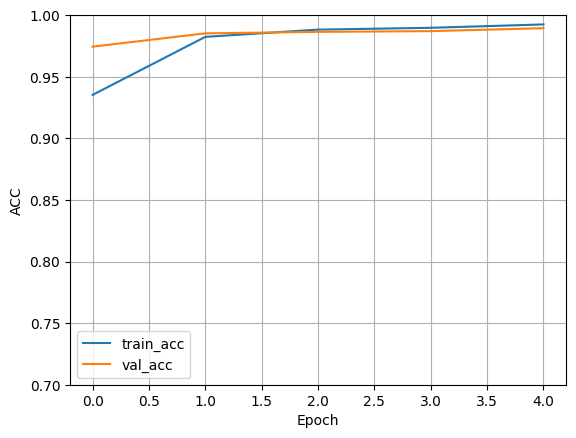

In [ ]:
plot_loss_and_acc(trainer.logger.log_dir)

In [ ]:
trainer.test(model=lightning_model, datamodule=dm)

C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.989799976348877
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.989799976348877}]

In [61]:
import torchvision.models as models

resnet_model = models.resnet18(pretrained = True)

# https://discuss.pytorch.org/t/changing-in-features-in-fc-layer-for-resnet18-in-torchvision/21445/2
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, 10)

# https://stackoverflow.com/questions/58364963/how-to-change-the-first-convolution-of-a-pretrained-resnet-in-tensorflow
resnet_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size = 7, stride = (2, 2), padding = (3, 3), bias = False)

lightning_model = LightningModel(model=resnet_model, learning_rate=0.1)

# Data augmentation
dm = MnistDataModule(batch_size=64)
dm.prepare_data()
dm.setup(True)

trainer = L.Trainer(
    max_epochs=5,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="res_net_model_no_alterations"),
    deterministic=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=lightning_model, datamodule=dm)


  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.2 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)


Epoch 0:  58%|█████▊    | 495/859 [01:40<01:13,  4.93it/s, v_num=1]        

In [ ]:
plot_loss_and_acc(trainer.logger.log_dir)

In [ ]:
trainer.test(model=lightning_model, datamodule=dm)